## 라이브러리 

In [1]:
import re    # 정규표현식 관련된 작업에 필요한 패키지
import os    # I/O 관련된 작업에 필요한 패키지 
import pandas as pd     # 데이터 전처리 관련된 작업에 필요한 패키지
import numpy as np      # 데이터 array 작업에 필요한 패키지
import tensorflow as tf  # 딥러닝 관련된 작업에 필요한 패키지
import matplotlib.pyplot as plt    # 데이터 시각화에 관련된 작업에 필요한 패키지
from sklearn.model_selection import train_test_split  # 데이터 전처리에 필요한 패키지

## 데이터 준비 및 전처리 

In [61]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 30

print(ROOT_PATH)

/home/aiffel-dj16/aiffel


데이터 들의 개수를 확인한다

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


validation data가 너무 적기 때문에, train과 valiodation의 데이터를 모아 다시 8:2 비율로 나눈다.

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

# train, test(val) dataset으로 분할. test_size에 0.2는 20%롤 의미함.
train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


배치 처리 작업을 효율적으로 하기위해서 tf.data를 사용한다.

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)


In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


라벨 이름을 확인한다.

In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


현재 이미지에는 라벨 데이터가 따로 없고, 이미지 이름 자체에 라벨이 들어가있기 때문에 이를 이용해 라벨 데이터를 만들어준다.

In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

이미지 크기는 작을수록 GPU 연산을 할 때 좋은 효율을 낼 수 있다. 이미지 크기를 통일하고 크기를 줄여준다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

train data set과 validation data set을 만드는데, 위에서 먼저 초기화해준 AUTOTUNE을 이용해 빠르게 처리할 수 있도록 한다.

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

의도대로 리사이즈와 라벨이 잘 들어갔는지 확인한다.

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


위에서 만들어준 것 과 같이 test data set을 만들어주고 개수를 확인한다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


아래 함수는 효율적인 학습을 할 수 있도록 데이터를 변환한다.

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat() #repeat을 사용하면 epoch마다 데이터를 불러오지 않고 
                    #한 데이터 셋을 여러번 이용할 수 있게 한다.

    ds = ds.batch(BATCH_SIZE)#BATCH_SIZE에 맞게 batch를 할당한다.

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

## 데이터 시각화 

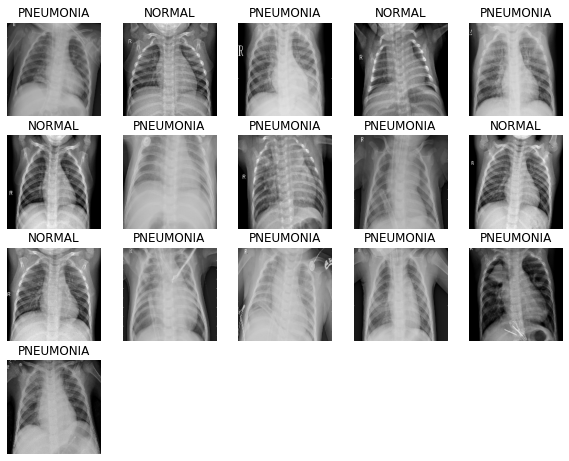

In [15]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링 

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [19]:
model = build_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

## 데이터 불균형 처리 

라벨 중에서 한쪽만 너무 많다면 불균형(imbalance)한 상태이다. 이런 데이터를 가지고 학습을  
진행한다면, 학습 효과를 기대하기 어려워지는데 이를 해결하기 위해 weight balancing이라는 방법이 있다. weight balancing은 training set의 각 데이터에서 loss를 계산할 때 어떤 특정 클래스의 데이터에 더 큰 loss를 갖도록 가중치를 부여하는 방법이다.  
현재의 토이 프로젝트에서는 pneumonia가 3115개로, 1070개인 normal 데이터보다 약 3배 가량 많은 데이터가 있다.(imabalnce한 데이터이다.)  
따라서 normal에 더 큰 가중치를 갖도록 해야한다. 

In [65]:
weight_for_0 = 0.8#0.8#(1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/6.0 
weight_for_1 = 0.2#(1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.80
Weight for class 1: 0.20


## 훈련 

In [66]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [67]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
261/261 [==============================] - 22s 83ms/step - loss: 0.1255 - accuracy: 0.8223 - precision: 0.9687 - recall: 0.7867 - val_loss: 0.6307 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/30
261/261 [==============================] - 21s 81ms/step - loss: 0.0930 - accuracy: 0.8807 - precision: 0.9746 - recall: 0.8624 - val_loss: 1.0638 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/30
261/261 [==============================] - 21s 80ms/step - loss: 0.0790 - accuracy: 0.9049 - precision: 0.9781 - recall: 0.8920 - val_loss: 0.2248 - val_accuracy: 0.9212 - val_precision: 0.9971 - val_recall: 0.8954
Epoch 4/30
261/261 [==============================] - 21s 81ms/step - loss: 0.0670 - accuracy: 0.9188 - precision: 0.9843 - recall: 0.9054 - val_loss: 0.1070 - val_accuracy: 0.9673 - val_precision: 0.9828 - val_recall: 0.9725
Epoch 5/30
261/261 [==============================] - 21s 80ms/step - loss: 0.0572 - accuracy: 0

## 결과 확인, 시각화 

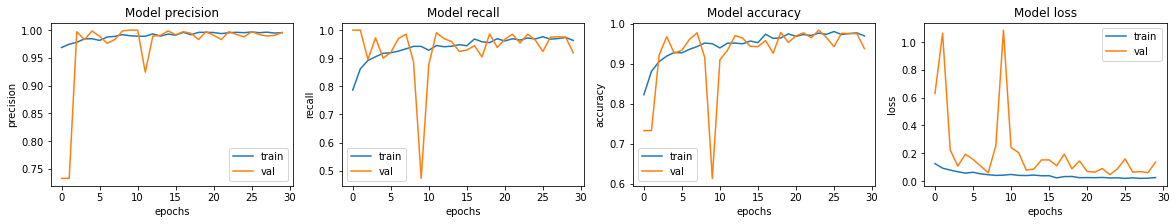

In [68]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [69]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 55ms/step - loss: 0.4131 - accuracy: 0.8942 - precision: 0.8821 - recall: 0.9590


accuracy 89%로 원하는 결과가 나왔다.  

## 회고  
데이터의 불균형이 학습결과에 꽤 큰 차이를 보인다는 것을 깨닳았다. 물론 weight balnacing만을 통해서 원하는 accuracy를 얻어내는 데에는 한계가 있어서 epoch를 올림으로써 해결했지만, 60%를 웃돌던 결과가 80%에 가까운 결과를 내는 것은 흥미로운 점이었다. 아쉬웠던 점은 weight balancing 도중에 변수를 통해 계산한 weight 값이 아니라 0.8, 0.2와 같이 상수로 정해주었던 점이었다. 이렇게 해서 안될껀 없지 않나 라는 생각으로 넣긴 했지만, 좀 더 분류해야 할 클래스가 많아지고, 그 데이터들이 imbalnce할 때 ㅁ